In [126]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [127]:
df.drop(columns=["Outcome"], inplace=True)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


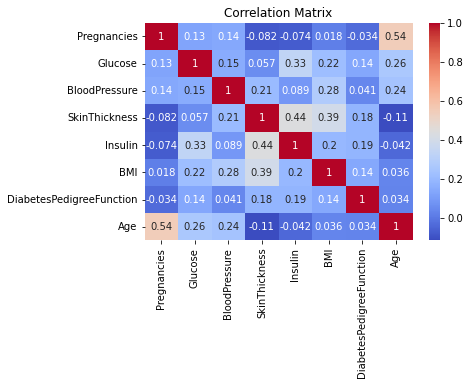

In [128]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [129]:
df.drop(columns=["Age", "Pregnancies"], inplace=True)
df

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,148,72,35,0,33.6,0.627
1,85,66,29,0,26.6,0.351
2,183,64,0,0,23.3,0.672
3,89,66,23,94,28.1,0.167
4,137,40,35,168,43.1,2.288
...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171
764,122,70,27,0,36.8,0.340
765,121,72,23,112,26.2,0.245
766,126,60,0,0,30.1,0.349


Text(0.5, 1.0, 'BMI Outlier Check')

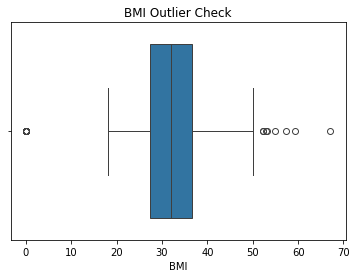

In [130]:
sns.boxplot(x=df['BMI'])
plt.title('BMI Outlier Check')

In [131]:
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 범위 지정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
df_clean = df[(df['BMI'] >= lower_bound) & (df['BMI'] <= upper_bound)]


Text(0.5, 1.0, 'BMI Outlier Check')

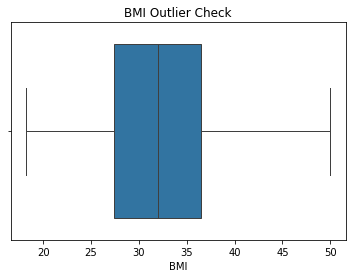

In [132]:
sns.boxplot(x=df_clean['BMI'])
plt.title('BMI Outlier Check')

In [133]:
# 데이터와 타겟 분리
X = df_clean.drop('BMI', axis=1).values
y = df_clean['BMI'].values

In [134]:
# 원-핫 인코딩(이진 분류이므로 생략)
#y = pd.get_dummies(y).values  #=> df일 때때
#y = to_categorical(y) # numpy 배열 일 때

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scaler = StandardScaler()
y = target_scaler.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [135]:
# 4. 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [136]:
# 5. DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [137]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((599, 5), (150, 5), (599, 1), (150, 1))

In [153]:
# 6. 회귀 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            #nn.BatchNorm1d(128),
            #nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [154]:
# 7. 디바이스 설정, 모델/손실/옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 8. 학습 루프
model.train()
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Test MSE: {mse:.4f}")

Epoch 1/30, Loss: 0.9108
Epoch 2/30, Loss: 0.8042
Epoch 3/30, Loss: 0.7473
Epoch 4/30, Loss: 0.7064
Epoch 5/30, Loss: 0.6866
Epoch 6/30, Loss: 0.6651
Epoch 7/30, Loss: 0.6761
Epoch 8/30, Loss: 0.6499
Epoch 9/30, Loss: 0.6355
Epoch 10/30, Loss: 0.6323
Epoch 11/30, Loss: 0.6340
Epoch 12/30, Loss: 0.6214
Epoch 13/30, Loss: 0.6193
Epoch 14/30, Loss: 0.6044
Epoch 15/30, Loss: 0.6109
Epoch 16/30, Loss: 0.6166
Epoch 17/30, Loss: 0.6015
Epoch 18/30, Loss: 0.5864
Epoch 19/30, Loss: 0.5820
Epoch 20/30, Loss: 0.5852
Epoch 21/30, Loss: 0.5784
Epoch 22/30, Loss: 0.5784
Epoch 23/30, Loss: 0.5717
Epoch 24/30, Loss: 0.5764
Epoch 25/30, Loss: 0.5648
Epoch 26/30, Loss: 0.5566
Epoch 27/30, Loss: 0.5508
Epoch 28/30, Loss: 0.5520
Epoch 29/30, Loss: 0.5484
Epoch 30/30, Loss: 0.5389


In [ ]:
# 평가
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.6943


In [157]:
# numpy 변환
preds = np.array(preds)
actuals = np.array(actuals)

# 역변환
preds_original = target_scaler.inverse_transform(preds)
actuals_original = target_scaler.inverse_transform(actuals)

In [158]:
# 성능 지표 계산
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
mse = mean_squared_error(actuals_original, preds_original)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_original, preds_original)

print(f"\n[평가 결과]")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 예시: 예측값 5개 출력
print("\n[예측 vs 실제 (일부)]")
for i in range(5):
    print(f"예측: {preds_original[i][0]:.2f}, 실제: {actuals_original[i][0]:.2f}")


[평가 결과]
Mean Squared Error (MSE): 29.2173
Root Mean Squared Error (RMSE): 5.4053
R² Score: 0.3885

[예측 vs 실제 (일부)]
예측: 36.29, 실제: 46.50
예측: 24.32, 실제: 33.70
예측: 26.72, 실제: 26.50
예측: 23.59, 실제: 24.80
예측: 24.42, 실제: 19.50


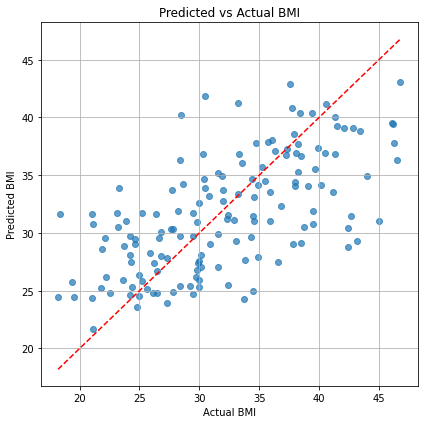

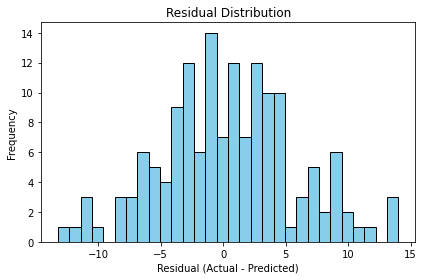

In [159]:
import matplotlib.pyplot as plt

# 1. 예측값 vs 실제값
plt.figure(figsize=(6, 6))
plt.scatter(actuals_original, preds_original, alpha=0.7)
plt.plot([actuals_original.min(), actuals_original.max()],
         [actuals_original.min(), actuals_original.max()], 'r--')
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title("Predicted vs Actual BMI")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Histogram (예측 오차 분포)
residuals = actuals_original - preds_original
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()